In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data from CSV
data = pd.read_csv('./drive/MyDrive/aist4010_project/form_records_cleaned.csv', index_col=0)

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Drop any irrelevant columns
data = data.drop(['Race_Index', 'Date'], axis=1)

# Perform normalization on numerical features
numerical_cols_minmax = ['Distance', 'Draw']
scaler_minmax = MinMaxScaler()
data[numerical_cols_minmax] = scaler_minmax.fit_transform(data[numerical_cols_minmax])

# Perform normalization on numerical features using StandardScaler
numerical_cols_norm = ['Rating', 'Win_Odds', 'Actual_Weight', 'Declared_Horse_Weight']
scaler_norm = StandardScaler()
data[numerical_cols_norm] = scaler_norm.fit_transform(data[numerical_cols_norm])

# Perform one-hot encoding on categorical variables
categorical_cols = ['Going', 'Race_Class','Track', 'Course']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(data[categorical_cols]))

# Perform normalization onFinish_Time_ms using StandardScaler
finish_time_cols_norm = ['Finish_Time_ms']
finish_time_norm = StandardScaler()
data[finish_time_cols_norm] = finish_time_norm.fit_transform(data[finish_time_cols_norm])

data = pd.concat([data.drop(categorical_cols, axis=1), encoded_cols], axis=1)

data = data.drop(['Place', 'RC'], axis=1)

data = data.dropna()

X = data.drop('Finish_Time_ms', axis=1).to_numpy()
y = (data['Finish_Time_ms']).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import math

# Model Architecture
class HorseRacingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(HorseRacingModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Training
input_size =  28
hidden_size =  2048
output_size =  1

model = HorseRacingModel(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500

test_loss_ls = list()
train_loss_ls = list()

for epoch in range(num_epochs):
    model.train()
    outputs = model(torch.from_numpy(X_train).to(torch.float32).to(device))
    loss = criterion(outputs, torch.from_numpy(y_train).to(torch.float32).unsqueeze(1).to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_ls.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Model Evaluation
    with torch.no_grad():
        model.eval()
        test_outputs = model(torch.from_numpy(X_test).to(torch.float32).to(device))
        test_loss = criterion(test_outputs, torch.from_numpy(y_test).to(torch.float32).unsqueeze(1).to(device))
        print(f"Test Loss: {test_loss.item()}")
        print(f"Test error (ms): {math.sqrt(test_loss.item() * finish_time_norm.var_.item())}")
        test_loss_ls.append(test_loss.item())

Epoch 1/500, Loss: 0.9993131160736084
Test Loss: 0.9404615163803101
Test error (ms): 17371.778291762545
Epoch 2/500, Loss: 0.9376027584075928
Test Loss: 0.5981769561767578
Test error (ms): 13854.428088769046
Epoch 3/500, Loss: 0.6021047234535217
Test Loss: 1.1805568933486938
Test error (ms): 19463.333500183046
Epoch 4/500, Loss: 1.1229525804519653
Test Loss: 0.6807185411453247
Test error (ms): 14779.425528438387
Epoch 5/500, Loss: 0.6818130612373352
Test Loss: 0.7711363434791565
Test error (ms): 15730.384904709907
Epoch 6/500, Loss: 0.7749154567718506
Test Loss: 0.41028735041618347
Test error (ms): 11474.078776641762
Epoch 7/500, Loss: 0.40903380513191223
Test Loss: 0.5183757543563843
Test error (ms): 12897.219871145086
Epoch 8/500, Loss: 0.5123500227928162
Test Loss: 0.5100736618041992
Test error (ms): 12793.52473026265
Epoch 9/500, Loss: 0.5079542994499207
Test Loss: 0.3280205726623535
Test error (ms): 10259.455327566431
Epoch 10/500, Loss: 0.3305715024471283
Test Loss: 0.39255538582

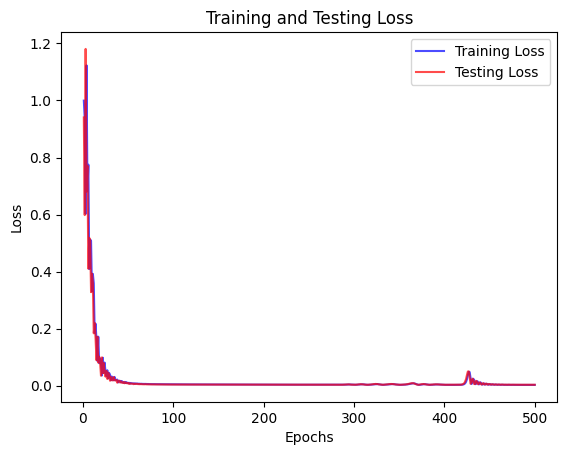

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(test_loss_ls) + 1)
plt.plot(epochs, train_loss_ls, 'b', label='Training Loss', alpha=0.7)
plt.plot(epochs, test_loss_ls, 'r', label='Testing Loss', alpha=0.7)
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()


In [ ]:
print(model)

HorseRacingModel(
  (fc1): Linear(in_features=28, out_features=2048, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=2048, out_features=1, bias=True)
)
